In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")


In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]
idx = 0

In [ ]:
import torch

train_X = torch.Tensor(eval_data)
train_y = torch.Tensor(eval_label)

test_X = torch.Tensor(test_data)
test_y = torch.Tensor(test_label)

eval_data = 0
eval_label = 0
test_data = 0
test_label = 0

#4-bit shallow_net

In [ ]:
!pip install brevitas

In [ ]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn

class Shallow_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = qnn.QuantConv1d(22, 40, 25, weight_bit_width=4)
    self.relu1 = nn.ReLU()

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.convs(x)

    self.fc1 = qnn.QuantLinear(self._to_linear, 2, bias=False, weight_bit_width=4)

  def convs(self, x):
    x = F.max_pool1d(F.relu(self.conv1(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    #return F.softmax(x, dim=1)
    return x


shallow_net = Shallow_Net()
#print(test_net)

'''
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

shallow_net.to(device)
'''



'\nif torch.cuda.is_available():\n  device = torch.device("cuda:0")\n  print("running on the gpu")\nelse:\n  device = torch.device("cpu")\n  print("running on the CPU")\n\nshallow_net.to(device)\n'

In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(shallow_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()


  0%|          | 0/27 [00:00<?, ?it/s]

0.38333333333333336 tensor(0.7148)
model-1620397560



100%|██████████| 27/27 [02:50<00:00,  6.30s/it]

100%|██████████| 27/27 [02:50<00:00,  6.31s/it]

100%|██████████| 27/27 [02:48<00:00,  6.24s/it]

100%|██████████| 27/27 [02:49<00:00,  6.29s/it]

100%|██████████| 27/27 [02:47<00:00,  6.21s/it]

100%|██████████| 27/27 [02:48<00:00,  6.23s/it]

100%|██████████| 27/27 [02:47<00:00,  6.22s/it]

100%|██████████| 27/27 [02:48<00:00,  6.23s/it]

100%|██████████| 27/27 [02:47<00:00,  6.20s/it]

100%|██████████| 27/27 [02:49<00:00,  6.27s/it]


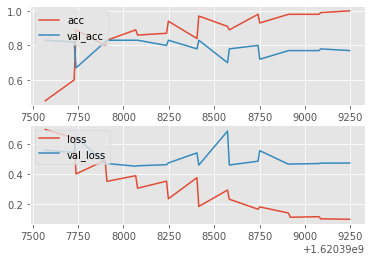

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


In [ ]:
def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = 0
  val_losses = 100
  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      if val_accs < float(val_acc):
        val_accs = float(val_acc)
      if val_losses > float(val_loss):
        val_losses = float(val_loss)
      
  print(f'{val_accs}, {val_losses}')
      #val_accs.append(float(val_acc))
      #val_losses.append(float(val_loss))

create_acc_loss_graph(MODEL_NAME)

0.83, 0.4538


# 2-bits


In [ ]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn

class Shallow_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = qnn.QuantConv1d(22, 40, 25, weight_bit_width=2)
    self.relu1 = nn.ReLU()

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.convs(x)

    self.fc1 = qnn.QuantLinear(self._to_linear, 2, bias=False, weight_bit_width=2)

  def convs(self, x):
    x = F.max_pool1d(F.relu(self.conv1(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    #return F.softmax(x, dim=1)
    return x


shallow_net = Shallow_Net()
#print(test_net)

'''
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

shallow_net.to(device)
'''



'\nif torch.cuda.is_available():\n  device = torch.device("cuda:0")\n  print("running on the gpu")\nelse:\n  device = torch.device("cpu")\n  print("running on the CPU")\n\nshallow_net.to(device)\n'

In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(shallow_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()


  0%|          | 0/27 [00:00<?, ?it/s]

0.6666666666666666 tensor(0.6628)
model-1620391463



100%|██████████| 27/27 [02:51<00:00,  6.34s/it]

100%|██████████| 27/27 [02:51<00:00,  6.36s/it]

100%|██████████| 27/27 [02:56<00:00,  6.53s/it]

100%|██████████| 27/27 [02:52<00:00,  6.39s/it]

100%|██████████| 27/27 [02:51<00:00,  6.35s/it]

100%|██████████| 27/27 [02:53<00:00,  6.42s/it]

100%|██████████| 27/27 [02:52<00:00,  6.39s/it]

100%|██████████| 27/27 [02:53<00:00,  6.41s/it]

100%|██████████| 27/27 [02:51<00:00,  6.35s/it]

100%|██████████| 27/27 [02:51<00:00,  6.36s/it]


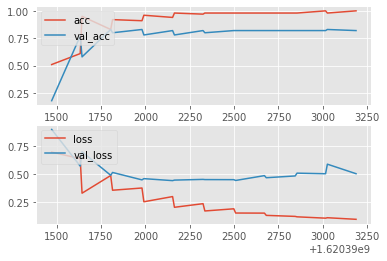

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


In [ ]:
contents = open("model.log", "r").read().split('\n')

In [ ]:
def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = 0
  val_losses = 100
  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      if val_accs < float(val_acc):
        val_accs = float(val_acc)
      if val_losses > float(val_loss):
        val_losses = float(val_loss)
      
  print(f'{val_accs}, {val_losses}')
      #val_accs.append(float(val_acc))
      #val_losses.append(float(val_loss))

create_acc_loss_graph(MODEL_NAME)

0.83, 0.4417


# 1-bit

In [ ]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn

class Shallow_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = qnn.QuantConv1d(22, 40, 25, weight_bit_width=1)
    self.relu1 = nn.ReLU()

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.convs(x)

    self.fc1 = qnn.QuantLinear(self._to_linear, 2, bias=False, weight_bit_width=1)

  def convs(self, x):
    x = F.max_pool1d(F.relu(self.conv1(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    #return F.softmax(x, dim=1)
    return x


shallow_net = Shallow_Net()
#print(test_net)

'''
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

shallow_net.to(device)
'''



'\nif torch.cuda.is_available():\n  device = torch.device("cuda:0")\n  print("running on the gpu")\nelse:\n  device = torch.device("cpu")\n  print("running on the CPU")\n\nshallow_net.to(device)\n'

In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(shallow_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  #outputs = torch.Tensor(outputs).long()
  #print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  #random_start = np.random.randint(len(test_X) - size)
  #X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  X, y = test_X, test_y
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 10

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()


  0%|          | 0/27 [00:00<?, ?it/s]

0.8333333333333334 tensor(nan)
model-1620393847



100%|██████████| 27/27 [02:47<00:00,  6.21s/it]

100%|██████████| 27/27 [02:47<00:00,  6.22s/it]

100%|██████████| 27/27 [02:47<00:00,  6.22s/it]

100%|██████████| 27/27 [02:46<00:00,  6.15s/it]

100%|██████████| 27/27 [02:44<00:00,  6.10s/it]

100%|██████████| 27/27 [02:44<00:00,  6.07s/it]

100%|██████████| 27/27 [02:42<00:00,  6.00s/it]

100%|██████████| 27/27 [02:43<00:00,  6.04s/it]

100%|██████████| 27/27 [02:44<00:00,  6.08s/it]

100%|██████████| 27/27 [02:45<00:00,  6.12s/it]


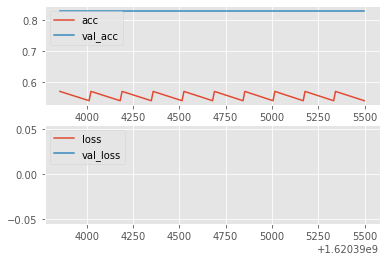

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


In [ ]:
def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = 0
  val_losses = 100
  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      if val_accs < float(val_acc):
        val_accs = float(val_acc)
      if val_losses > float(val_loss):
        val_losses = float(val_loss)
      
  print(f'{val_accs}, {val_losses}')
      #val_accs.append(float(val_acc))
      #val_losses.append(float(val_loss))

create_acc_loss_graph(MODEL_NAME)

0.83, 100
